# dMMSB

In [1]:
import os 
import sys
import jax
import jax.numpy as jnp
from jax.nn import softmax

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from utils.plots import plot_roles, plot_adjacency_matrix
from utils.utils import compute_best_permutation, l1_loss

from models.dMMSB import jitdMMSB


## Generation

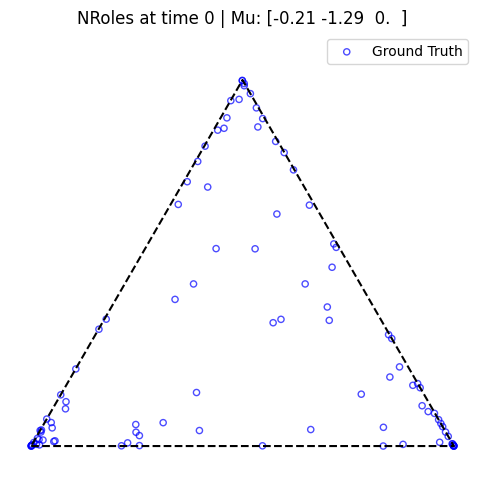

Mu at time 0: [-0.21 -1.29]


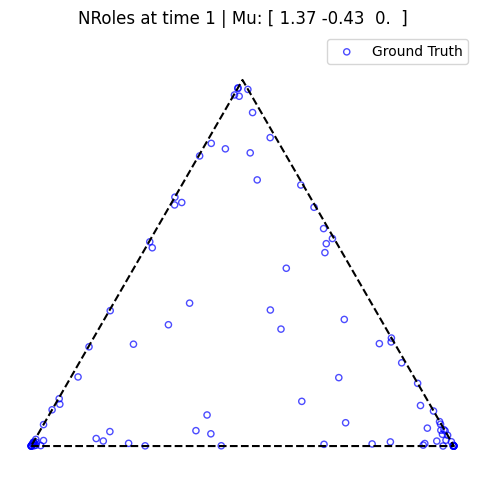

Mu at time 1: [ 1.37 -0.43]


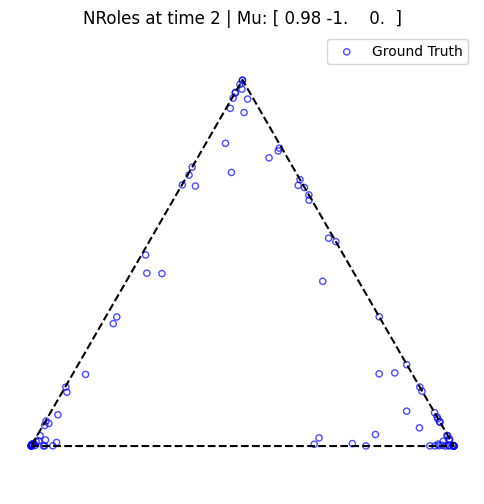

Mu at time 2: [ 0.98 -1.  ]


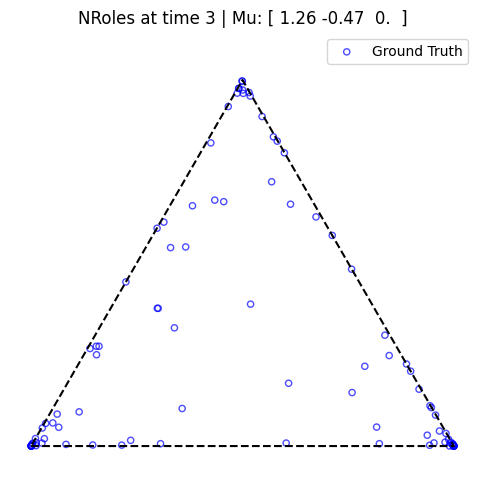

Mu at time 3: [ 1.26 -0.47]


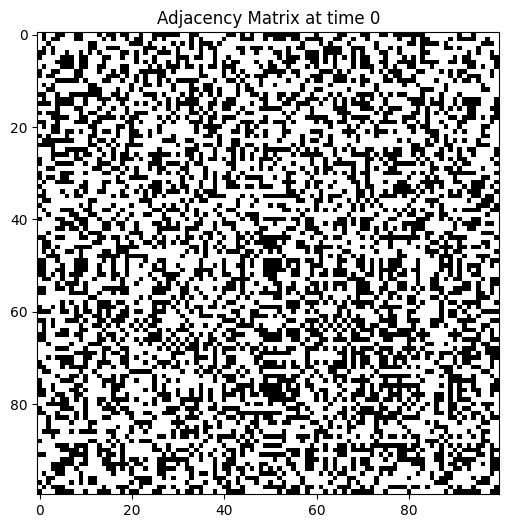

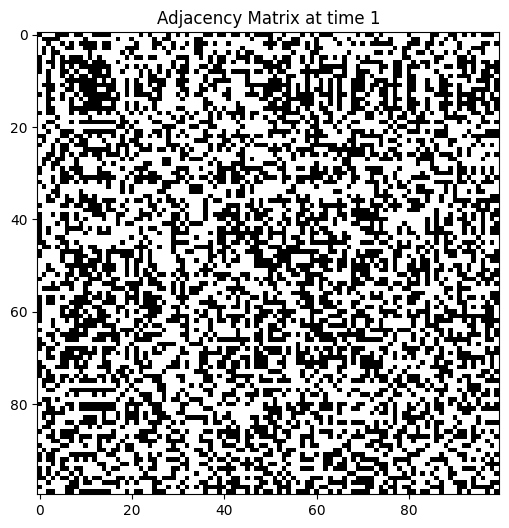

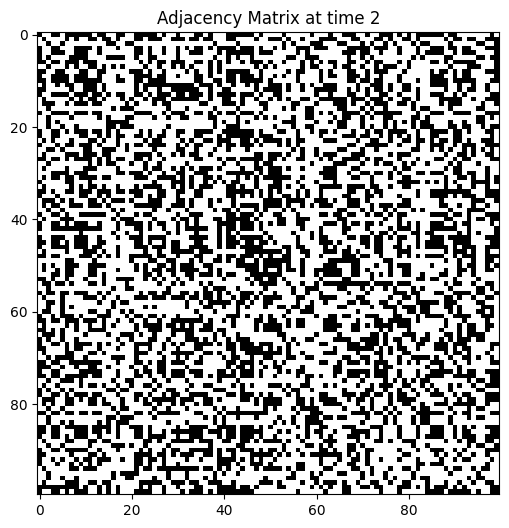

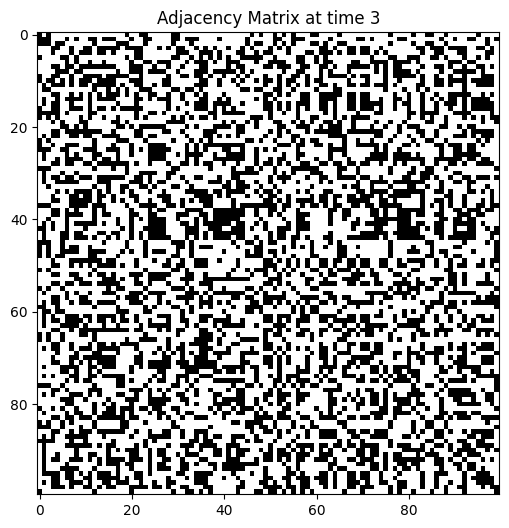

In [2]:
N = 100
K = 3
T = 4

nu =  jnp.array([0,0]) # Use K-1 dimension
Phi = jnp.array([[1,.5],
                 [.5,1]], dtype=jnp.float32) * 1
Sigma = jnp.tile(jnp.eye(2)[None, :, :], (T, 1, 1)) * 20 # Use K-1 dimension and T=4
B = jnp.array([[1,0.3,0],
               [0.3,1,0],
               [0,0,1]], dtype=jnp.float32) 



gen_model = jitdMMSB(nodes=N, roles=K, timesteps=T, key=jax.random.PRNGKey(42), Sigma=Sigma, B=B, Phi=Phi, nu=nu)
E_sample = gen_model.generate_graph()


for t in range(E_sample.shape[0]):
    #plot_adjacency_matrix(E_sample[t], title=f"Adjacency Matrix at time {t}")
    expanded_gamma = jnp.concatenate([gen_model.gamma_tilde[t], jnp.zeros((gen_model.N, 1))], axis=-1) # shape (T,N,K)
    expanded_mu = jnp.concatenate([gen_model.mu[t], jnp.zeros((1,))], axis=-1) # shape (,K)
    pis = softmax(expanded_gamma, axis=-1)
    jnp.set_printoptions(precision=2, suppress=True)
    plot_roles(pis, title=f"NRoles at time {t} | Mu: {expanded_mu}")
    print(f"Mu at time {t}: {gen_model.mu[t]}")

for t in range(E_sample.shape[0]):
    plot_adjacency_matrix(E_sample[t], title=f"Adjacency Matrix at time {t}")   

# Inference

As mentioned in the paper, its best to run the model with multiple random restarts to obtain better results.

In [3]:
restarts = 5

best_model = None
best_ll = -jnp.inf
for run in range(restarts):
    print(f"Run {run+1}")

    model = jitdMMSB(nodes=100, roles=3, timesteps=4, key=jax.random.PRNGKey(10+run))
    ll = model.fit(E_sample, max_inner_iters=1000, max_outer_iters=200, tol=1e-6, verbose=True)

    if ll > best_ll:
        best_ll = ll
        best_model = model
    print(f"Current ll:{ll} | Best ll:{best_ll}")

Run 1
Best initialization log-likelihood: -6257.584
Current ll:-6256.0654296875 | Best ll:-6256.0654296875
Run 2
Best initialization log-likelihood: -6180.6216
Current ll:-6293.998046875 | Best ll:-6256.0654296875
Run 3
Best initialization log-likelihood: -6256.794
Current ll:-6256.03515625 | Best ll:-6256.03515625
Run 4
Best initialization log-likelihood: -6223.705
Current ll:-6255.453125 | Best ll:-6255.453125
Run 5
Best initialization log-likelihood: -6360.91
Current ll:-6258.173828125 | Best ll:-6255.453125


### Role Matrix Recovery

In [4]:
jnp.set_printoptions(precision=3, suppress=True)
print("Best Model Role Matrix:")
print(best_model.B)
print("Ground Truth Role Matrix:")
print(B)



Best Model Role Matrix:
[[1.    0.    0.271]
 [0.    1.    0.   ]
 [0.266 0.    1.   ]]
Ground Truth Role Matrix:
[[1.  0.3 0. ]
 [0.3 1.  0. ]
 [0.  0.  1. ]]


### Role Comparison

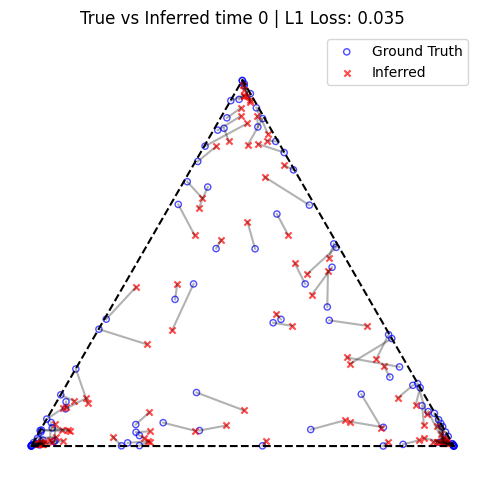

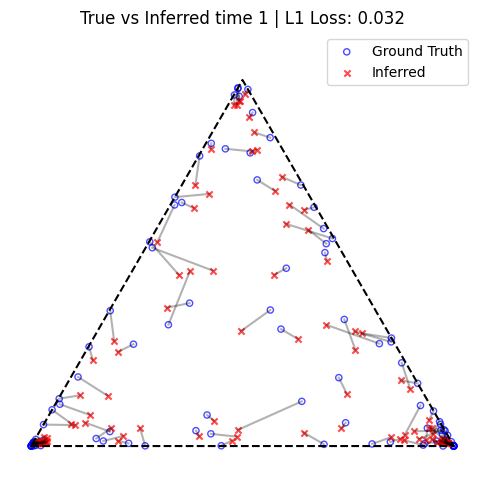

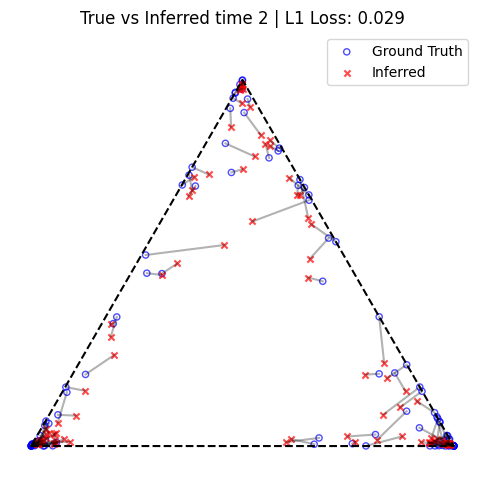

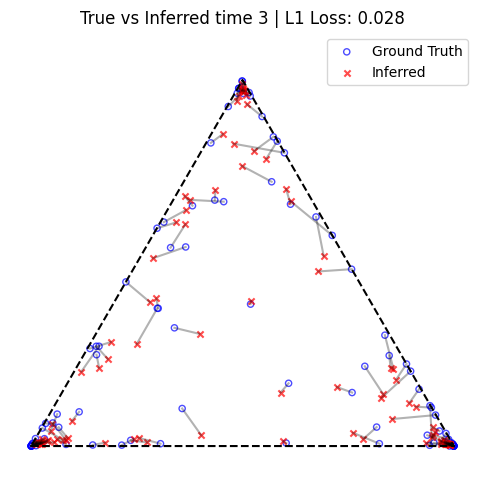

In [5]:
inferred_gammas = jnp.concatenate([best_model.gamma_tilde, jnp.zeros((best_model.T, best_model.N, 1))], axis=-1) # shape (T,N,K)
true_gammas = jnp.concatenate([gen_model.gamma_tilde, jnp.zeros((gen_model.T, gen_model.N, 1))], axis=-1) # shape (T,N,K)
inferred_roles = softmax(inferred_gammas, axis=-1) # shape (T,N,K)
true_roles = softmax(true_gammas, axis=-1) # shape (T,N,K)

for t in range(E_sample.shape[0]):
    perm = compute_best_permutation(true_roles[t], inferred_roles[t])
    plot_roles(true_roles[t], inferred_roles[t][:, perm], title=f"True vs Inferred time {t} | L1 Loss: {l1_loss(true_roles[t], inferred_roles[t][:, perm]):.3f}")